In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Setup yolov5

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt -q

Cloning into 'yolov5'...
remote: Enumerating objects: 17075, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 17075 (delta 29), reused 30 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17075/17075), 15.69 MiB | 21.71 MiB/s, done.
Resolving deltas: 100% (11723/11723), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 19.1 MB/s eta 0:00:00


Install additional dependencies

In [ ]:
!pip install paddlepaddle paddleocr -q
!pip install opencv-python -q
!pip install rapidfuzz -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.7/544.7 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.6 MB/s eta 0:00:00


Imports

In [ ]:
import os
import re

from pathlib import Path
from IPython.display import display

import requests
import torch
import numpy as np

from PIL import Image
from paddleocr import PaddleOCR
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rapidfuzz import fuzz, process

Initialize PaddleOCR

In [ ]:
OCR = PaddleOCR(use_angle_cls=True, lang='en')  # need to run only once to download and load model

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 3910/3910 [00:16<00:00, 242.08it/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10000/10000 [00:17<00:00, 576.11it/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2138/2138 [00:03<00:00, 578.27it/s]

[2024/12/11 06:17:34] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

Initialising grocery items reference data

In [ ]:
GROCERY_DATA = {
    "Bakery": [
        "Britannia Whole Wheat Bread",
        "Modern Milk Bread",
        "Britannia Brown Bread",
        "Britannia Rusk",
        "Sunfeast Marie Light Cake",
        "Britannia Fruit Cake"
    ],
    "Beverages": [
        "Coca-Cola",
        "Pepsi",
        "Sprite",
        "Frooti Mango Drink",
        "Pepsi Diet",
        "Tropicana Orange Juice",
        "Red Bull Energy Drink",
        "Pepsi Zero Sugar",
        "Mother Dairy Lassi",
        "Hershey's Chocolate Milkshake"
    ],
    "Biscuits": [
        "Parle-G Biscuits",
        "Britannia Marie Gold Biscuits",
        "Britannia Bourbon Biscuits",
        "Britannia Good Day Butter Cookies",
        "Hide & Seek Chocolate Chip Cookies",
        "Oreo Original Biscuits",
        "McVitie's Digestive Biscuits"
    ],
    "Breakfast-Cereal": [
        "Kellogg's Corn Flakes",
        "Bagrry's Muesli",
        "Quaker Oats",
        "Saffola Oats",
        "Kellogg's Chocos",
        "Yogabar Granola"
    ],
    "Chips": [
        "Lays Potato Chips",
        "Lays Honey Butter Chips",
        "Lays Masala Chips",
        "Bingo Mad Angles",
        "Haldiram’s Aloo Bhujia",
        "Lays Barbecue Chips"
    ],
    "Chocolates": [
        "Cadbury Dairy Milk",
        "Nestle KitKat Bar",
        "Nestle Munch",
        "Snickers Chocolate Bar",
        "Ferrero Rocher",
        "Amul Dark Chocolate",
        "Toblerone Swiss Chocolate"
    ],
    "Dairy-Products": [
        "Amul Gold Milk",
        "Mother Dairy Milk",
        "Amul Butter",
        "Britannia Cheese Slices",
        "Amul Mozzarella Cheese",
        "Amul Fresh Cream",
        "Nestlé Dahi (Curd)"
    ],
    "Lentils-Grains": [
        "Tata Sampann Toor Dal",
        "Organic Tattva Moong Dal",
        "BB Royal Chana Dal",
        "Daawat Basmati Rice",
        "Aashirvaad Whole Wheat Atta",
        "Fortune Sona Masoori Rice"
    ],
    "Pasta-Noodles": [
        "Maggi 2-Minute Noodles",
        "Sunfeast Yippee Noodles",
        "Del Monte Spaghetti",
        "Disano Penne Pasta",
        "Knorr Soupy Noodles",
        "Prego Pasta Sauce (Tomato Basil)"
    ],
    "Spreads-Sauces": [
        "Kissan Mixed Fruit Jam",
        "Nutella Hazelnut Spread",
        "Pillsbury Peanut Butter",
        "Dabur Honey",
        "Nestlé Maggi Tomato Ketchup",
        "Hellmann's Mayonnaise",
        "Ching's Schezwan Chutney"
    ],
    "Tea-Coffee": [
        "Tata Tea Gold",
        "Brooke Bond Red Label",
        "Wagh Bakri Premium Tea",
        "Nescafé Classic Coffee",
        "Bru Instant Coffee",
        "Blue Tokai Coffee Beans"
    ]
}

PACKED_ITEMS = ["Bakery", "Beverages", "Biscuits", "Breakfast-Cereal", "Chips", "Chocolates", "Dairy-Products", "Lentils-Grains", "Pasta-Noodles", "Spreads-Sauces", "Tea-Coffee"]

Set similarity threshold for vector matching

In [ ]:
SIMILARITY_THRESHOLD = 0.2 # Adjust this threshold as needed

Load your model

In [ ]:
weights_path = "/content/drive/MyDrive/weights/best.pt" # Replace this with the path to your weights
MODEL = torch.hub.load('ultralytics/yolov5', 'custom', path=weights_path, force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2024-12-11 Python-3.10.12 torch-2.5.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 7099126 parameters, 0 gradients, 16.0 GFLOPs
Adding AutoShape... 


Utility Funtions

In [ ]:
def download_images(output_dir: Path, urls: list) -> None:
  """Downloads images from a list of URLs and saves them to a directory.

  Args:
      output_dir: The directory to save the images to.
      urls: A list of image URLs to download.

  Returns:
      None
  """
  output_dir.mkdir(parents=True, exist_ok=True)
  i = 0
  for image_url in urls:
    response = requests.get(image_url)
    image_path = os.path.join(output_dir, f"image_{i}.jpg")
    with open(image_path, 'wb') as f:
      f.write(response.content)

In [ ]:
def ocr_image(image: Image.Image) -> str:
  """Performs OCR on a Pillow Image.

  Args:
      image: The image to perform OCR on (PIL.Image.Image).

  Returns:
      A string containing the OCR results.
  """
  image_np = np.array(image)
  result = OCR.ocr(image_np, cls=True)
  extracted_texts = []
  for line in result:
    if not line:
      continue
    for word_info in line:
        if word_info[1][1] > 0.7:  # Check confidence score
            text = word_info[1][0]  # Get the detected text
            extracted_texts.append(text)  # Add it to the list

  # Join into a single string
  final_text = ' '.join(extracted_texts)
  return final_text

In [ ]:
def find_product(ocr_output: str, label) -> None:
  """
    Find the best matching grocery product from a reference database using OCR text.

    This function processes OCR text from a grocery item and finds the closest match
    in a predefined GROCERY_DATA reference list using a combination of fuzzy string
    matching and cosine similarity.

    The matching process involves:
    1. Text preprocessing (removing special characters, converting to lowercase)
    2. Word-level fuzzy matching using token set ratio
    3. Vectorization of matched text
    4. Cosine similarity calculation for final matching

    Args:
        ocr_output (str): The raw text output from OCR processing of a grocery item image

    Global Variables Used:
        GROCERY_DATA (List[str]): Reference list of grocery product names
        SIMILARITY_THRESHOLD (float): Minimum similarity score (0-1) required for a match

    Returns:
        None: Prints the matching results to console, including:
            - Original OCR output
            - Preprocessed OCR text
            - Best fuzzy-matched reference text
            - Best matching product from database
            - Similarity score as percentage

    Example:
        >>> find_product("heinz tomato ketchp")
        OCR Output: heinz tomato ketchp
        Preprocessed OCR Output: heinz tomato ketchp
        Best Fuzzy-Matched Reference: heinz tomato ketchup
        Best Match: Heinz Tomato Ketchup 32oz
        Similarity Score: 92.45%

    Note:
        - Function uses fuzzy matching threshold of 70% for word-level matching
        - Prints "No match found" if similarity score is below SIMILARITY_THRESHOLD
  """
  # preprocess text
  def preprocess_text_for_vectorization(text):
      cleaned_text = re.sub(r"[^a-zA-Z0-9\s]", '', text.lower()) # Remove special characters, lowercase
      words = re.split(r'\s+', cleaned_text)  # Split by whitespace
      filtered_words = [word for word in words if len(word) > 2] # Remove and filter out unnecessary short words
      unique_words = list(dict.fromkeys(filtered_words)) # Remove consecutive duplicate words
      return unique_words

  # Function to do word-level fuzzy matching
  def fuzzy_match_words(ocr_words, reference_words, threshold=70):
      matched_words = []
      for ocr_word in ocr_words:
          best_match, score, _ = process.extractOne(ocr_word, reference_words, scorer=fuzz.token_set_ratio)
          if score > threshold:  # Only keep matches above the threshold
              matched_words.append(best_match)
      return matched_words

  # preprocess
  preprocessed_reference_items = [preprocess_text_for_vectorization(item) for item in GROCERY_DATA[label]]
  preprocessed_ocr_output = preprocess_text_for_vectorization(ocr_output)

  # Fuzzy match the words from the OCR output with the words from each reference item
  fuzzy_matched_items = []
  for reference_words in preprocessed_reference_items:
      #print(reference_words)
      matched_words = fuzzy_match_words(preprocessed_ocr_output, reference_words)
      fuzzy_matched_items.append(' '.join(matched_words))  # Rejoin words into a string after matching

  # vectorize the fuzzy-matched reference items and the ocr output
  vectorizer = CountVectorizer().fit_transform(fuzzy_matched_items + [' '.join(preprocessed_ocr_output)])
  vectors = vectorizer.toarray()

  # cosine similarity between the fuzzy matched ocr output and reference items
  cosine_similarities = cosine_similarity([vectors[-1]], vectors[:-1])

  # Find the best match based on cosine similarity
  best_match_idx = cosine_similarities[0].argmax()
  best_similarity_score = cosine_similarities[0][best_match_idx] * 100  # Convert to percentage
  best_match = GROCERY_DATA.get(label) # Use .get() to avoid KeyError if label is not found
  if best_match is None:
    print(f"No product data found for label: {label}")
    return  # Exit early if no data for the label
  best_match = best_match[best_match_idx]  # Get the specific product from the list

  # print results
  if best_similarity_score < SIMILARITY_THRESHOLD * 100:
    print("No match found")
  else:
      print(f"OCR Output: {ocr_output}")
      print(f"Preprocessed OCR Output: {' '.join(preprocessed_ocr_output)}")
      print(f"Best Fuzzy-Matched Reference: {fuzzy_matched_items[best_match_idx]}")
      print(f"Best Match: {best_match}")
      print(f"Similarity Score: {best_similarity_score:.2f}%")

In [ ]:
def get_prediction_for_image(image_path: Path) -> Image.Image | None:
  """
   Process an image to detect grocery items, crop detected regions, and perform OCR + product matching.

   This function uses an object detection model to identify grocery items in an image,
   crops the detected regions, performs OCR on each crop, and attempts to match the
   text with a reference product database.

   Args:
       image_path (Path): Path to the input image file

   Global Variables Used:
       MODEL: YOLOv5 object detection model

   Returns:
       Image.Image | None: Returns None if no objects are detected with confidence > 0.5

   Process:
       1. Runs object detection model on input image
       2. Filters predictions with confidence > 0.5
       3. For each detected object:
           - Crops the bounding box region
           - Performs OCR on the cropped region
           - Attempts to match OCR text with reference product database

   Example:
       >>> get_prediction_for_image(Path("grocery_shelf.jpg"))
       Cropped Image for: cereal_box
       OCR Output: cheerios whole grain oats
       Best Match: Cheerios Original Cereal 18oz
       Similarity Score: 95.32%

   Note:
       - Uses confidence threshold of 0.5 for filtering predictions
       - Displays cropped images and matching results during processing
       - Requires 'MODEL' to be pre-loaded with appropriate weights
       - Relies on external 'ocr_image' and 'find_product' functions for text extraction and matching
  """
  predictions = MODEL(image_path)
  predictions_df = predictions.pandas().xyxy[0]

  filtered_predictions = predictions_df[predictions_df['confidence'] > 0.5]

  if filtered_predictions.empty:
    return None
  original_image = Image.open(image_path)
  # Iterate over each bounding box
  for index, row in filtered_predictions.iterrows():
      # Extract bounding box coordinates
      xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
      label = row['name']  # Get the class label

      # Crop the bounding box from the original image
      cropped_image = original_image.crop((xmin, ymin, xmax, ymax))

      # Display the cropped image
      print(f"Cropped Image for: {label}")
      display(cropped_image)
      if label in PACKED_ITEMS:
        ocr_output = ocr_image(cropped_image)
        print(f"OCR Output: {ocr_output}")
        if not ocr_output:
          print(f"OCR did not detect anything for label {label}")
          continue
        find_product(ocr_output, label)
      else:
        print(f"Detected Item is {label}")


Main Function





Cropped Image for: Breakfast-Cereal


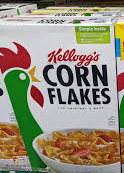

[2024/12/11 06:17:49] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.15248847007751465
[2024/12/11 06:17:49] ppocr DEBUG: cls num  : 3, elapsed : 0.04894304275512695
[2024/12/11 06:17:49] ppocr DEBUG: rec_res num  : 3, elapsed : 0.31230735778808594
OCR Output: Kelloyg's CORN FLAKES
OCR Output: Kelloyg's CORN FLAKES
Preprocessed OCR Output: kelloygs corn flakes
Best Fuzzy-Matched Reference: kelloggs corn flakes
Best Match: Kellogg's Corn Flakes
Similarity Score: 66.67%
Cropped Image for: Breakfast-Cereal


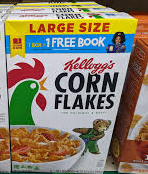

[2024/12/11 06:17:49] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.128767728805542
[2024/12/11 06:17:49] ppocr DEBUG: cls num  : 6, elapsed : 0.05570578575134277
[2024/12/11 06:17:50] ppocr DEBUG: rec_res num  : 6, elapsed : 0.9683594703674316
OCR Output: LARGE SIZE 1FREEBOOK Kellogg's CORN FLAKES
OCR Output: LARGE SIZE 1FREEBOOK Kellogg's CORN FLAKES
Preprocessed OCR Output: large size 1freebook kelloggs corn flakes
Best Fuzzy-Matched Reference: kelloggs corn flakes
Best Match: Kellogg's Corn Flakes
Similarity Score: 70.71%








Cropped Image for: Orange


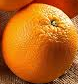

Detected Item is Orange
Cropped Image for: Orange


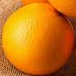

Detected Item is Orange
Cropped Image for: Orange


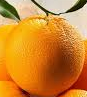

Detected Item is Orange








Cropped Image for: Watermelon


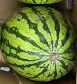

Detected Item is Watermelon
Cropped Image for: Watermelon


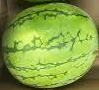

Detected Item is Watermelon
Cropped Image for: Watermelon


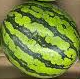

Detected Item is Watermelon
Cropped Image for: Watermelon


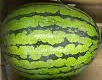

Detected Item is Watermelon
Cropped Image for: Watermelon


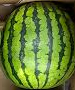

Detected Item is Watermelon
Cropped Image for: Watermelon


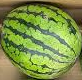

Detected Item is Watermelon








Cropped Image for: Broccoli


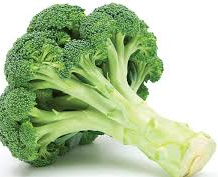

Detected Item is Broccoli








Cropped Image for: Onion


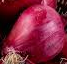

Detected Item is Onion
Cropped Image for: Onion


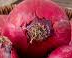

Detected Item is Onion
Cropped Image for: Onion


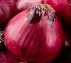

Detected Item is Onion
Cropped Image for: Onion


Detected Item is Onion
Cropped Image for: Onion


Detected Item is Onion
Cropped Image for: Onion


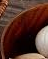

Detected Item is Onion
Cropped Image for: Onion


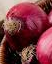

Detected Item is Onion








Cropped Image for: Biscuits


[2024/12/11 06:17:55] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08377408981323242
[2024/12/11 06:17:55] ppocr DEBUG: cls num  : 1, elapsed : 0.030379295349121094
[2024/12/11 06:17:55] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10235476493835449
OCR Output: 
OCR did not detect anything for label Biscuits








Cropped Image for: Spreads-Sauces


[2024/12/11 06:17:55] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.07663512229919434
[2024/12/11 06:17:55] ppocr DEBUG: cls num  : 3, elapsed : 0.017895936965942383
[2024/12/11 06:17:56] ppocr DEBUG: rec_res num  : 3, elapsed : 0.15898966789245605
OCR Output: kisSan MIXED FRUIT -JAM
OCR Output: kisSan MIXED FRUIT -JAM
Preprocessed OCR Output: kissan mixed fruit jam
Best Fuzzy-Matched Reference: kissan mixed fruit jam
Best Match: Kissan Mixed Fruit Jam
Similarity Score: 100.00%








Cropped Image for: Dairy-Products


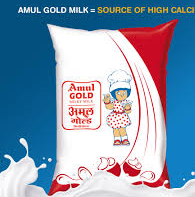

[2024/12/11 06:17:57] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08456087112426758
[2024/12/11 06:17:57] ppocr DEBUG: cls num  : 3, elapsed : 0.02298116683959961
[2024/12/11 06:17:57] ppocr DEBUG: rec_res num  : 3, elapsed : 0.148850679397583
OCR Output: GOLD
OCR Output: GOLD
Preprocessed OCR Output: gold
Best Fuzzy-Matched Reference: gold
Best Match: Amul Gold Milk
Similarity Score: 100.00%








Cropped Image for: Biscuits


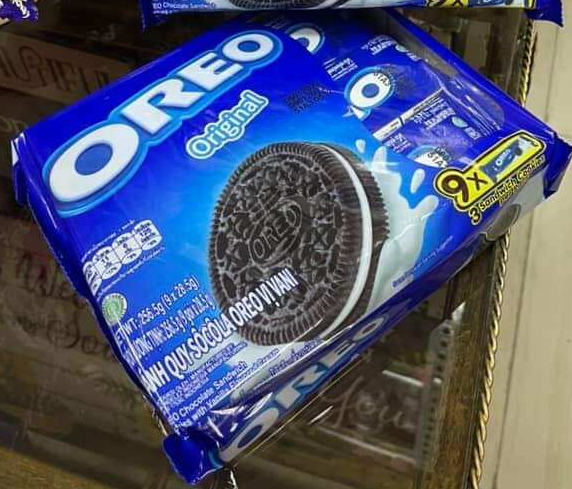

[2024/12/11 06:17:58] ppocr DEBUG: dt_boxes num : 5, elapsed : 0.2928435802459717
[2024/12/11 06:17:58] ppocr DEBUG: cls num  : 5, elapsed : 0.050005435943603516
[2024/12/11 06:17:58] ppocr DEBUG: rec_res num  : 5, elapsed : 0.3289821147918701
OCR Output: TWT:256.5g (928.5g) NH QUY SOCOLA OREOVIVANI
No match found
Cropped Image for: Biscuits


[2024/12/11 06:17:58] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.24942588806152344
[2024/12/11 06:17:59] ppocr DEBUG: cls num  : 11, elapsed : 0.05461740493774414
[2024/12/11 06:17:59] ppocr DEBUG: rec_res num  : 11, elapsed : 0.5899484157562256
OCR Output: OREO Original NH OUYSOCOLA OREOVIVANI
OCR Output: OREO Original NH OUYSOCOLA OREOVIVANI
Preprocessed OCR Output: oreo original ouysocola oreovivani
Best Fuzzy-Matched Reference: oreo original
Best Match: Oreo Original Biscuits
Similarity Score: 70.71%








Cropped Image for: Chips


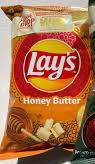

[2024/12/11 06:18:00] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.08163952827453613
[2024/12/11 06:18:00] ppocr DEBUG: cls num  : 2, elapsed : 0.05469965934753418
[2024/12/11 06:18:00] ppocr DEBUG: rec_res num  : 2, elapsed : 0.15781164169311523
OCR Output: Lay's Honey Butte
OCR Output: Lay's Honey Butte
Preprocessed OCR Output: lays honey butte
Best Fuzzy-Matched Reference: lays honey butter
Best Match: Lays Honey Butter Chips
Similarity Score: 66.67%
Cropped Image for: Chips


[2024/12/11 06:18:00] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.08899903297424316
[2024/12/11 06:18:00] ppocr DEBUG: cls num  : 3, elapsed : 0.0181276798248291
[2024/12/11 06:18:00] ppocr DEBUG: rec_res num  : 3, elapsed : 0.19764089584350586
OCR Output: OROPWIN Lay's wavi
OCR Output: OROPWIN Lay's wavi
Preprocessed OCR Output: oropwin lays wavi
Best Fuzzy-Matched Reference: lays
Best Match: Lays Potato Chips
Similarity Score: 57.74%
Cropped Image for: Chips


[2024/12/11 06:18:00] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.025629043579101562
[2024/12/11 06:18:01] ppocr DEBUG: cls num  : 2, elapsed : 0.026055574417114258
[2024/12/11 06:18:01] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16121172904968262
OCR Output: Lay's Masala
OCR Output: Lay's Masala
Preprocessed OCR Output: lays masala
Best Fuzzy-Matched Reference: lays masala
Best Match: Lays Masala Chips
Similarity Score: 100.00%








Cropped Image for: Chips


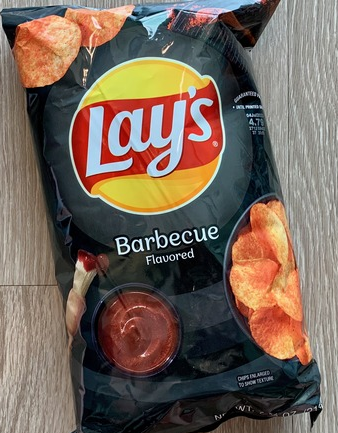

[2024/12/11 06:18:02] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.2068483829498291
[2024/12/11 06:18:02] ppocr DEBUG: cls num  : 3, elapsed : 0.023177146911621094
[2024/12/11 06:18:02] ppocr DEBUG: rec_res num  : 3, elapsed : 0.23319292068481445
OCR Output: Lay's Barbecue Flavored
OCR Output: Lay's Barbecue Flavored
Preprocessed OCR Output: lays barbecue flavored
Best Fuzzy-Matched Reference: lays barbecue
Best Match: Lays Barbecue Chips
Similarity Score: 81.65%








Cropped Image for: Pasta-Noodles


[2024/12/11 06:18:03] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.04609346389770508
[2024/12/11 06:18:03] ppocr DEBUG: cls num  : 3, elapsed : 0.026233196258544922
[2024/12/11 06:18:03] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2613053321838379
OCR Output: QUAKER OATS
No match found
Cropped Image for: Breakfast-Cereal


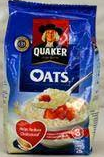

[2024/12/11 06:18:03] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.03364372253417969
[2024/12/11 06:18:04] ppocr DEBUG: cls num  : 3, elapsed : 0.029155254364013672
[2024/12/11 06:18:04] ppocr DEBUG: rec_res num  : 3, elapsed : 0.2270793914794922
OCR Output: QUAKER OATS
OCR Output: QUAKER OATS
Preprocessed OCR Output: quaker oats
Best Fuzzy-Matched Reference: quaker oats
Best Match: Quaker Oats
Similarity Score: 100.00%








Cropped Image for: Chocolates


[2024/12/11 06:18:05] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.6771717071533203
[2024/12/11 06:18:06] ppocr DEBUG: cls num  : 17, elapsed : 0.0927736759185791
[2024/12/11 06:18:07] ppocr DEBUG: rec_res num  : 17, elapsed : 1.2754542827606201
OCR Output: Per bar R Energy 876k Nestle at 209kcal 10% it of an adult's RI 210kJ/502kcal JEAR HERE xcea Plan'
OCR Output: Per bar R Energy 876k Nestle at 209kcal 10% it of an adult's RI 210kJ/502kcal JEAR HERE xcea Plan'
Preprocessed OCR Output: per bar energy 876k nestle 209kcal adults 210kj502kcal jear here xcea plan
Best Fuzzy-Matched Reference: bar nestle
Best Match: Nestle KitKat Bar
Similarity Score: 40.82%








Cropped Image for: Dairy-Products


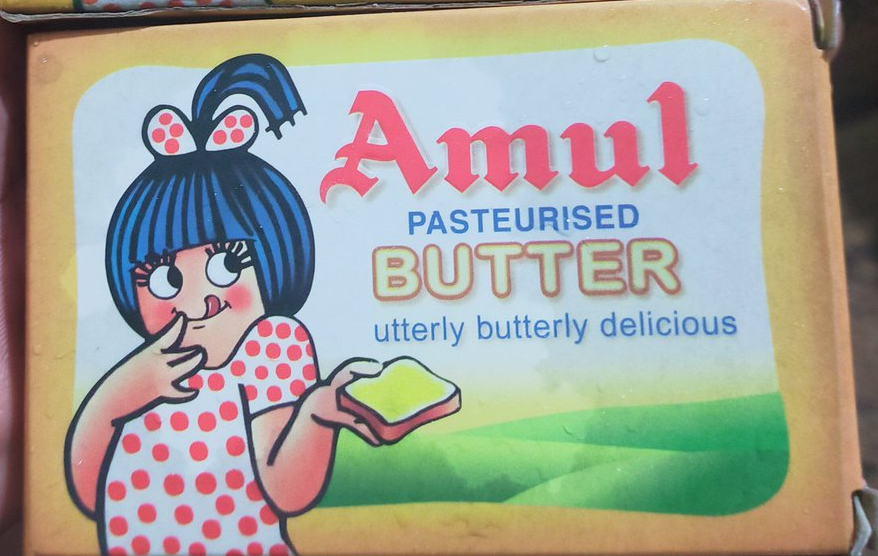

[2024/12/11 06:18:08] ppocr DEBUG: dt_boxes num : 4, elapsed : 0.4416530132293701
[2024/12/11 06:18:08] ppocr DEBUG: cls num  : 4, elapsed : 0.05484437942504883
[2024/12/11 06:18:09] ppocr DEBUG: rec_res num  : 4, elapsed : 0.9202804565429688
OCR Output: Amul PASTEURISED BUTTER utterly butterly delicious
OCR Output: Amul PASTEURISED BUTTER utterly butterly delicious
Preprocessed OCR Output: amul pasteurised butter utterly butterly delicious
Best Fuzzy-Matched Reference: amul butter butter butter
Best Match: Amul Butter
Similarity Score: 51.64%








Cropped Image for: Beverages


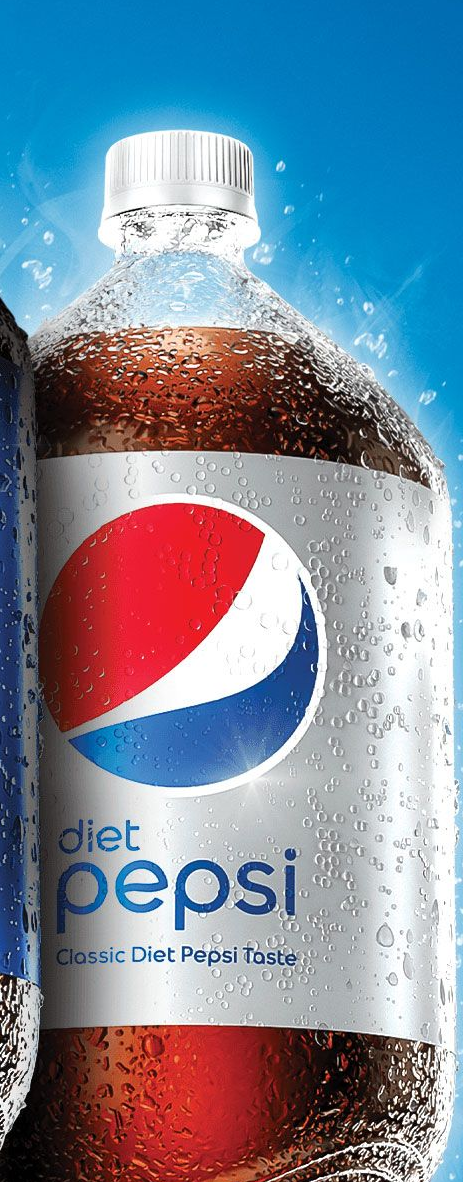

[2024/12/11 06:18:11] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.32087016105651855
[2024/12/11 06:18:11] ppocr DEBUG: cls num  : 3, elapsed : 0.017580032348632812
[2024/12/11 06:18:11] ppocr DEBUG: rec_res num  : 3, elapsed : 0.40582847595214844
OCR Output: diet pepsi Classic Diet Pepsi Taste
OCR Output: diet pepsi Classic Diet Pepsi Taste
Preprocessed OCR Output: diet pepsi classic taste
Best Fuzzy-Matched Reference: diet pepsi
Best Match: Pepsi Diet
Similarity Score: 70.71%
Cropped Image for: Beverages


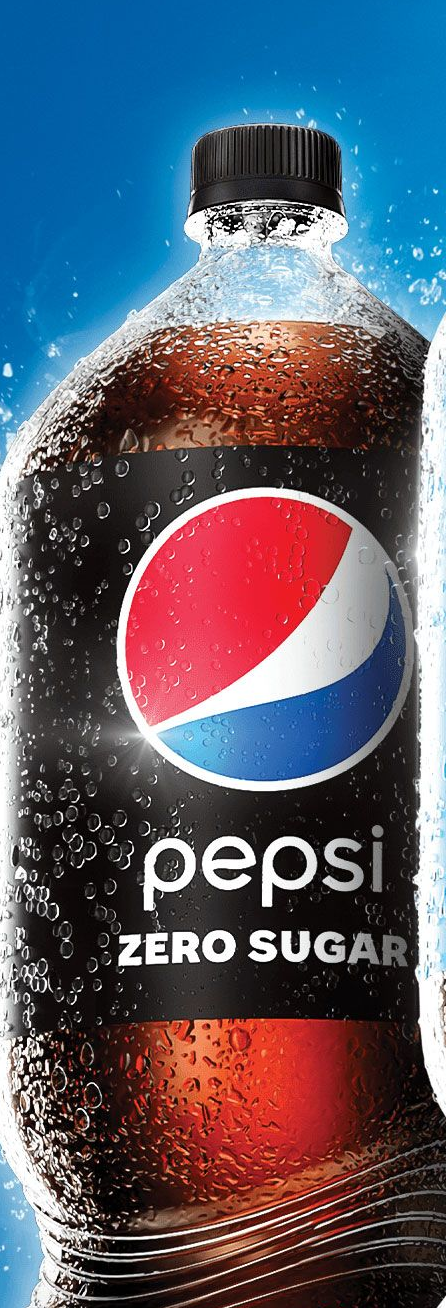

[2024/12/11 06:18:12] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.2805037498474121
[2024/12/11 06:18:12] ppocr DEBUG: cls num  : 2, elapsed : 0.04666948318481445
[2024/12/11 06:18:12] ppocr DEBUG: rec_res num  : 2, elapsed : 0.2642092704772949
OCR Output: pepsi ZERO SUGAR
OCR Output: pepsi ZERO SUGAR
Preprocessed OCR Output: pepsi zero sugar
Best Fuzzy-Matched Reference: pepsi zero sugar
Best Match: Pepsi Zero Sugar
Similarity Score: 100.00%








Cropped Image for: Potato


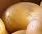

Detected Item is Potato
Cropped Image for: Potato


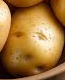

Detected Item is Potato
Cropped Image for: Potato


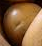

Detected Item is Potato
Cropped Image for: Potato


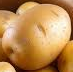

Detected Item is Potato
Cropped Image for: Potato


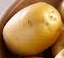

Detected Item is Potato
Cropped Image for: Potato


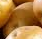

Detected Item is Potato
Cropped Image for: Potato


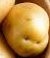

Detected Item is Potato
Cropped Image for: Potato


Detected Item is Potato








Cropped Image for: Beverages


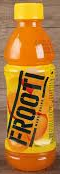

[2024/12/11 06:18:14] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08594846725463867
[2024/12/11 06:18:14] ppocr DEBUG: cls num  : 1, elapsed : 0.04977130889892578
[2024/12/11 06:18:14] ppocr DEBUG: rec_res num  : 1, elapsed : 0.158111572265625
OCR Output: 
OCR did not detect anything for label Beverages








Cropped Image for: Bell-Pepper


Detected Item is Bell-Pepper
Cropped Image for: Bell-Pepper


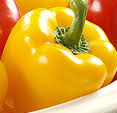

Detected Item is Bell-Pepper
Cropped Image for: Onion


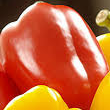

Detected Item is Onion
Cropped Image for: Bell-Pepper


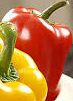

Detected Item is Bell-Pepper
Cropped Image for: Carrot


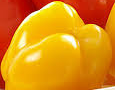

Detected Item is Carrot






In [ ]:
# Uncomment if you want to  download images from urls and process
# OUTPUT_DIRECTORY = Path("/content/images")
# IMAGE_URLS = [
#     "https://pbs.twimg.com/media/DVnjo_jVMAAElMy.jpg:large",
# ]

# download_images(OUTPUT_DIRECTORY, IMAGE_URLS)

OUTPUT_DIRECTORY = Path("/content/drive/MyDrive/inference")

for filename in os.listdir(OUTPUT_DIRECTORY):
    if filename.endswith((".jpg", '.jpeg', '.png')):
        image_path = os.path.join(OUTPUT_DIRECTORY, filename)
        print("\n\n\n")
        get_prediction_for_image(image_path)
        print("\n\n\n")


In [ ]:
# DELETE THIS
import shutil

shutil.rmtree(OUTPUT_DIRECTORY)